# ИБС кардиограммы

Исследование задачи ИБС (Дьяконов А.Г., 2016)

Все признаки предварительно получаются в Матлабе

**второй ноутбук: правильное тестирование и настройка**

In [83]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np


# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Загрузка данных

Признаковые матрицы посчитаны в Матлабе

In [2]:
yy = pd.read_csv('d:\\Competitions\\Shmid\\yy.txt', header=None)
f_fft = pd.read_csv('d:\\Competitions\\Shmid\\F_fft.txt', header=None)
f_fft_smooth = pd.read_csv('d:\\Competitions\\Shmid\\F_fft_smooth.txt', header=None)
f_poly = pd.read_csv('d:\\Competitions\\Shmid\\F_poly.txt', header=None)

print (yy.shape, f_fft.shape, f_fft_smooth.shape, f_poly.shape)

(3029, 3) (3029, 47) (3029, 235) (3029, 40)


In [4]:
yy.columns = ['y', 'people', 'id']
yy[:3]

,y,people,id
0,1,1403,16588
1,1,1403,16589
2,1,1961,19666


In [10]:
y = yy.y.values # целевой признак
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [11]:
people = yy.people.values # метки людей
people[:10]

array([1403, 1403, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961], dtype=int64)

In [69]:
# все-все признаки
f_all = pd.concat([f_fft, f_fft_smooth, f_poly], axis=1)
f_all.shape

(3029, 322)

### Запуск алгоритмов

* 20 фолдов (пациент целиком попадает в фолд)
* Используем ансамбль деревьев, но при построении каждого дерева от каждого пациента берём не более 10 сигналов

In [86]:
# побольше фолдов
from sklearn.cross_validation import LabelKFold
# cv2 = LabelKFold(labels, n_folds=len(set(labels)))
cv = LabelKFold(people, n_folds=20)

In [87]:
from random import shuffle
# выбрать индексы так,
# что у группы помеченной одной меткой label выбирается не более 10
def subsample(labels, k_cut=10):
    tmp = pd.DataFrame({'labels': labels})
    g = tmp.groupby('labels').groups
    inds = []
    for i in g.values():
        shuffle(i)
        if len(i)>k_cut:
            inds.extend(i[:k_cut])
        else:
            inds.extend(i)
    return (inds)

In [60]:
subsample([1,1,1,2,2,2,2,3,4,5,5,5,5,5], 2)

[2, 0, 4, 3, 7, 8, 13, 10]

In [88]:
from sklearn.ensemble import RandomForestRegressor

# строить алгоритмы по подвыборкам
def run_myalgo(train, y, labels, test):
    clf = RandomForestRegressor(n_estimators=1, n_jobs=-1, random_state=1)
    n_iter = 30 # число деревьев (а там 1)
    a = np.zeros(test.shape[0])
    for i in range(n_iter):
        inds = subsample(labels)
        clf.fit(train[inds,:], y[inds])
        a += clf.predict(test)
    a /= n_iter
    return (a)

In [89]:
from time import time

# на всех признаковых пространствах
# прогнать мой алгоритм

a = np.zeros(y.shape)
a1 = np.zeros(y.shape)
a2 = np.zeros(y.shape)
a3 = np.zeros(y.shape)

tm = time()
for itrain, itest in cv:
    a[itest] = run_myalgo(f_all.values[itrain,:], y[itrain], people[itrain], f_all.values[itest,:])
    a1[itest] = run_myalgo(f_fft.values[itrain,:], y[itrain], people[itrain], f_fft.values[itest,:])
    a2[itest] = run_myalgo(f_fft_smooth.values[itrain,:], y[itrain], people[itrain], f_fft_smooth.values[itest,:])
    a3[itest] = run_myalgo(f_poly.values[itrain,:], y[itrain], people[itrain], f_poly.values[itest,:])
    print (time() - tm)

26.4535129070282
54.38611078262329
82.86573958396912
112.35542631149292
142.9631769657135
175.56604170799255
206.49181056022644
237.32757425308228
268.56836128234863
299.1041076183319
328.1197671890259
360.42061471939087
390.8353543281555
422.13714480400085
453.6679482460022
483.4826536178589
515.1984674930573
545.6992123126984
576.803991317749
606.7037014961243


(0.6, 0.85)

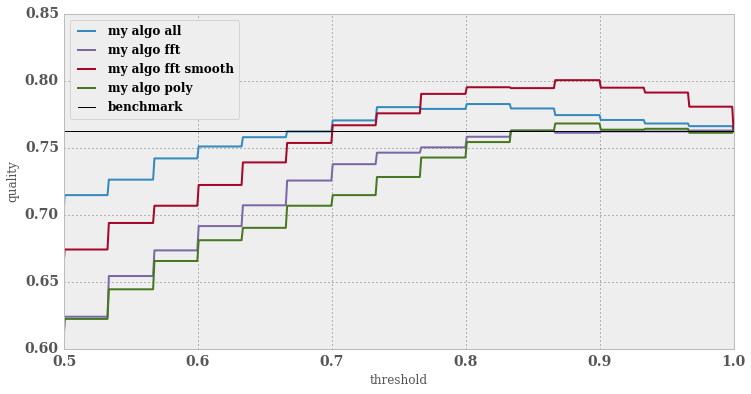

In [75]:
# это если брать по 10 в обучение...

figsize(12, 6)
lsp = np.linspace(0, 1, 1000)
plt.plot(lsp, [np.mean(np.abs((a>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, [np.mean(np.abs((a1>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, [np.mean(np.abs((a2>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, [np.mean(np.abs((a3>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, np.mean(np.abs(0 == y)) + lsp*0, 'k')
plt.xlabel('threshold')
plt.ylabel('quality')
plt.legend(['my algo all', 'my algo fft', 'my algo fft smooth', 'my algo poly', 'benchmark'], 0)
plt.xlim([0.5, 1])
plt.ylim([0.6, 0.85])

(0.6, 0.85)

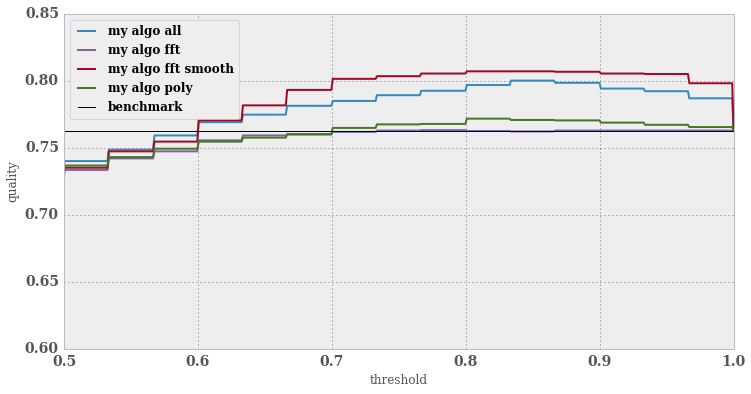

In [91]:
# это если брать всё в обучение...

figsize(12, 6)
lsp = np.linspace(0, 1, 1000)
plt.plot(lsp, [np.mean(np.abs((a>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, [np.mean(np.abs((a1>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, [np.mean(np.abs((a2>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, [np.mean(np.abs((a3>l) == y)) for l in lsp], lw=2)
plt.plot(lsp, np.mean(np.abs(0 == y)) + lsp*0, 'k')
plt.xlabel('threshold')
plt.ylabel('quality')
plt.legend(['my algo all', 'my algo fft', 'my algo fft smooth', 'my algo poly', 'benchmark'], 0)
plt.xlim([0.5, 1])
plt.ylim([0.6, 0.85])

In [ ]:
np.mean(np.abs((a2>0.89) == y))

In [92]:
a_this = a2
threshold = 0.85

tmp = pd.DataFrame({'label':people, 'y':y, 'a':a_this, 'ans': 0+(a_this>threshold)})
tmp['q'] = tmp.y == tmp.ans
print ('качество по сигналам = ' + str(tmp.q.mean()))
print ('качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))

tmp[:3]

# было
# качество по сигналам = 0.813469792011
# качество по людям = 0.590329376155

качество по сигналам = 0.807197094751
качество по людям = 0.605456310685


,a,ans,label,y,q
0,0.466667,0,1403,1,False
1,0.500000,0,1403,1,False
2,0.733333,0,1961,1,False


In [ ]:
качество по сигналам = 0.796962693958
качество по людям = 0.61103582909


качество по сигналам = 0.80059425553
качество по людям = 0.591142996655